In [1]:
import pandas as pd
import numpy as np
import time
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
import tensorflow as tf

In [91]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)


In [55]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
df = pd.read_csv("../data/data_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
df['production_usage'] = df['production_usage'].fillna(df['production_usage'].median())

df['fve'] = df['fve'] * 0.03
df['mve'] = df['mve'] * 0.07
df['wpg'] = df['wpg'] * 0.07

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               35040 non-null  datetime64[ns]
 1   shops              35040 non-null  float64       
 2   office_building    35040 non-null  float64       
 3   industrial_park    35040 non-null  float64       
 4   fve                35036 non-null  float64       
 5   mve                35036 non-null  float64       
 6   wpg                35036 non-null  float64       
 7   price              35040 non-null  float64       
 8   isWeekend          35040 non-null  int64         
 9   isHoliday          35040 non-null  int64         
 10  production_usage   35036 non-null  float64       
 11  consumption_usage  35040 non-null  float64       
 12  temp               35040 non-null  float64       
 13  wind               35040 non-null  int64         
 14  hour  

In [84]:
# features_considered =  [
#                     'consumption_usage','production_usage','price', 'isWeekend', 
#                     'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
#                     'month_cos', 'month_sin'
#                     ]
features_considered =  [
                    'consumption_usage','price', 'isWeekend', 
                    'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                    'month_cos', 'month_sin'
                    ]
TRAIN_SPLIT = 10000
BUFFER_SIZE = 5000
BATCH_SIZE = 64
features = df[features_considered][:20000]
features.index = df['date'][:20000]
features.head()


,consumption_usage,price,isWeekend,isHoliday,temp,wind,day_cos,day_sin,month_cos,month_sin
date,,,,,,,,,,
2020-01-01 00:00:00,76.404,33.2,0,1,-8.0,3,1.000000,0.000000,0.999963,-0.008601
2020-01-01 00:15:00,72.212,33.2,0,1,-8.0,3,1.000000,0.000000,0.999965,-0.008422
2020-01-01 00:30:00,70.992,33.2,0,1,-8.0,3,1.000000,0.000000,0.999966,-0.008243
2020-01-01 00:45:00,70.872,33.2,0,1,-8.0,3,1.000000,0.000000,0.999967,-0.008064
2020-01-01 01:00:00,80.540,30.4,0,1,-8.4,3,0.965926,0.258819,0.999969,-0.007884


In [85]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

,consumption_usage,price,isWeekend,isHoliday,temp,wind,day_cos,day_sin,month_cos,month_sin
date,,,,,,,,,,
2020-01-01 00:00:00,-0.848409,0.101901,-0.621136,5.647543,-1.592548,-0.368076,1.411547,-0.000830,1.238732,-2.426741
2020-01-01 00:15:00,-0.889828,0.101901,-0.621136,5.647543,-1.592548,-0.368076,1.411547,-0.000830,1.238735,-2.426143
2020-01-01 00:30:00,-0.901882,0.101901,-0.621136,5.647543,-1.592548,-0.368076,1.411547,-0.000830,1.238738,-2.425544
2020-01-01 00:45:00,-0.903068,0.101901,-0.621136,5.647543,-1.592548,-0.368076,1.411547,-0.000830,1.238742,-2.424946
2020-01-01 01:00:00,-0.807543,-0.085415,-0.621136,5.647543,-1.658280,-0.368076,1.363381,0.365369,1.238745,-2.424347


In [86]:
past_history = 192 # 2days
future_target = 16 # 4hours
STEP = 1
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)
print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target usage to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(9808, 192, 10)
(9808, 16)
Single window of past history : (192, 10)
Target usage to predict : (16,)


In [87]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [88]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(16))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 192, 32)           5504      
_________________________________________________________________
lstm_16 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
Total params: 8,912
Trainable params: 8,912
Non-trainable params: 0
_________________________________________________________________
None


In [100]:
pastHistory_range = x_train_multi.shape[-2:][0]
number_of_features = x_train_multi.shape[-2:][1]

192

In [89]:
EPOCHS = 100
EVALUATION_INTERVAL = 10
#early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                         # callbacks=[early_stopping]
                                         )

Epoch 1/100
10/10 [==============================] - 4s 186ms/step - loss: 0.9469 - val_loss: 0.8490
Epoch 2/100
10/10 [==============================] - 1s 153ms/step - loss: 0.7830 - val_loss: 0.8278
Epoch 3/100
10/10 [==============================] - 1s 153ms/step - loss: 0.7028 - val_loss: 0.8064
Epoch 4/100
10/10 [==============================] - 1s 153ms/step - loss: 0.5690 - val_loss: 0.7594
Epoch 5/100
10/10 [==============================] - 2s 172ms/step - loss: 0.5321 - val_loss: 0.6838
Epoch 6/100
10/10 [==============================] - 2s 191ms/step - loss: 0.4868 - val_loss: 0.6508
Epoch 7/100
10/10 [==============================] - 2s 169ms/step - loss: 0.4567 - val_loss: 0.5894
Epoch 8/100
10/10 [==============================] - 1s 144ms/step - loss: 0.4009 - val_loss: 0.5230
Epoch 9/100
10/10 [==============================] - 1s 142ms/step - loss: 0.3596 - val_loss: 0.5311
Epoch 10/100
10/10 [==============================] - 1s 147ms/step - loss: 0.3530 - val_lo

10/10 [==============================] - 2s 178ms/step - loss: 0.2044 - val_loss: 0.3349
Epoch 82/100
10/10 [==============================] - 2s 181ms/step - loss: 0.2197 - val_loss: 0.2968
Epoch 83/100
10/10 [==============================] - 2s 180ms/step - loss: 0.2028 - val_loss: 0.3403
Epoch 84/100
10/10 [==============================] - 2s 209ms/step - loss: 0.1969 - val_loss: 0.3201
Epoch 85/100
10/10 [==============================] - 2s 223ms/step - loss: 0.1837 - val_loss: 0.2956
Epoch 86/100
10/10 [==============================] - 2s 192ms/step - loss: 0.1980 - val_loss: 0.3173
Epoch 87/100
10/10 [==============================] - 2s 181ms/step - loss: 0.2063 - val_loss: 0.3190
Epoch 88/100
10/10 [==============================] - 2s 196ms/step - loss: 0.1943 - val_loss: 0.3257
Epoch 89/100
10/10 [==============================] - 2s 189ms/step - loss: 0.1981 - val_loss: 0.3244
Epoch 90/100
10/10 [==============================] - 2s 181ms/step - loss: 0.1931 - val_loss: 

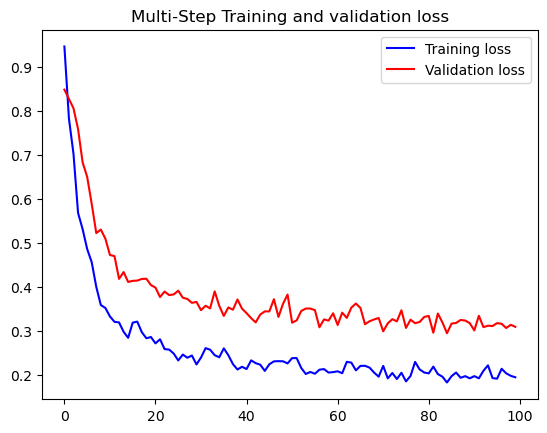

In [92]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

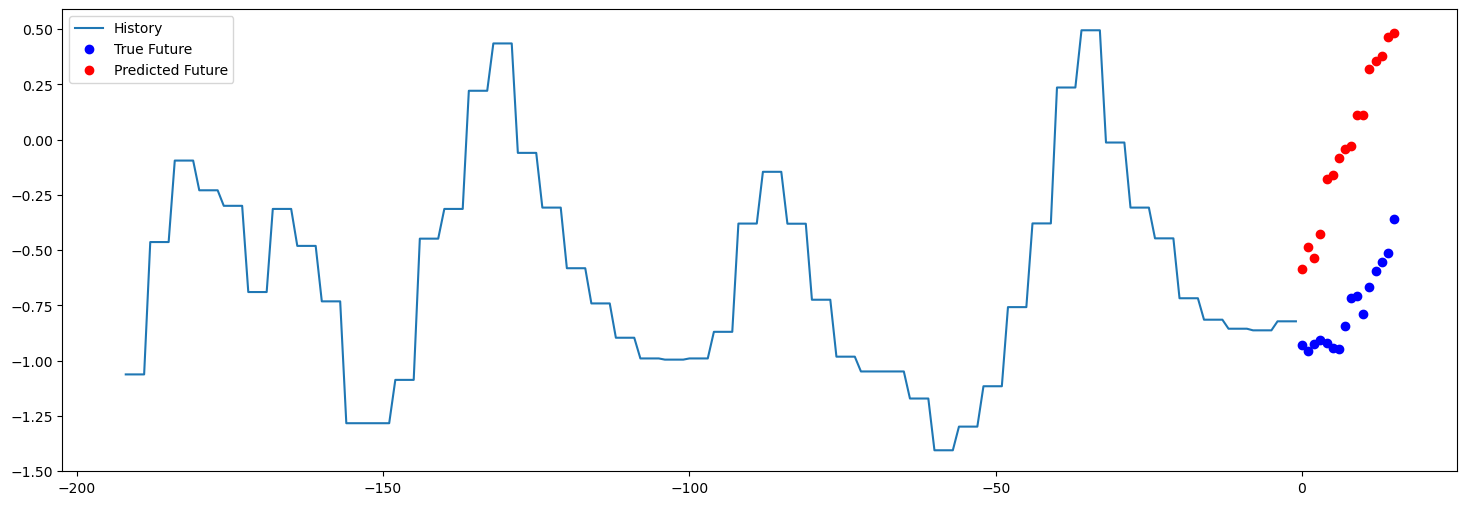

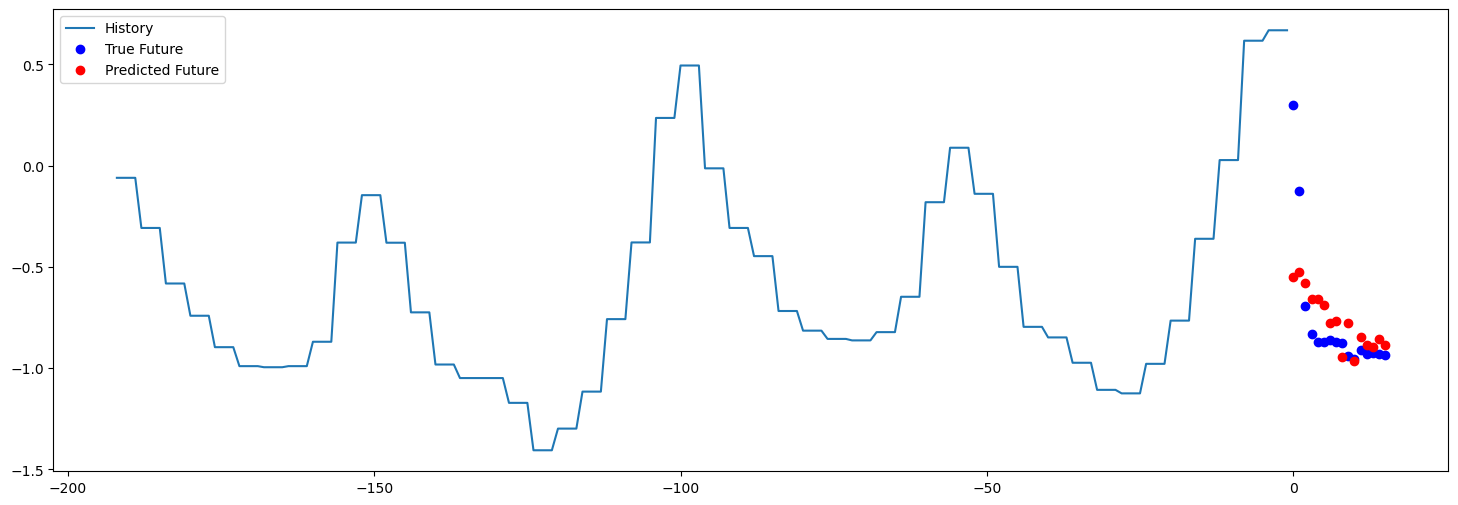

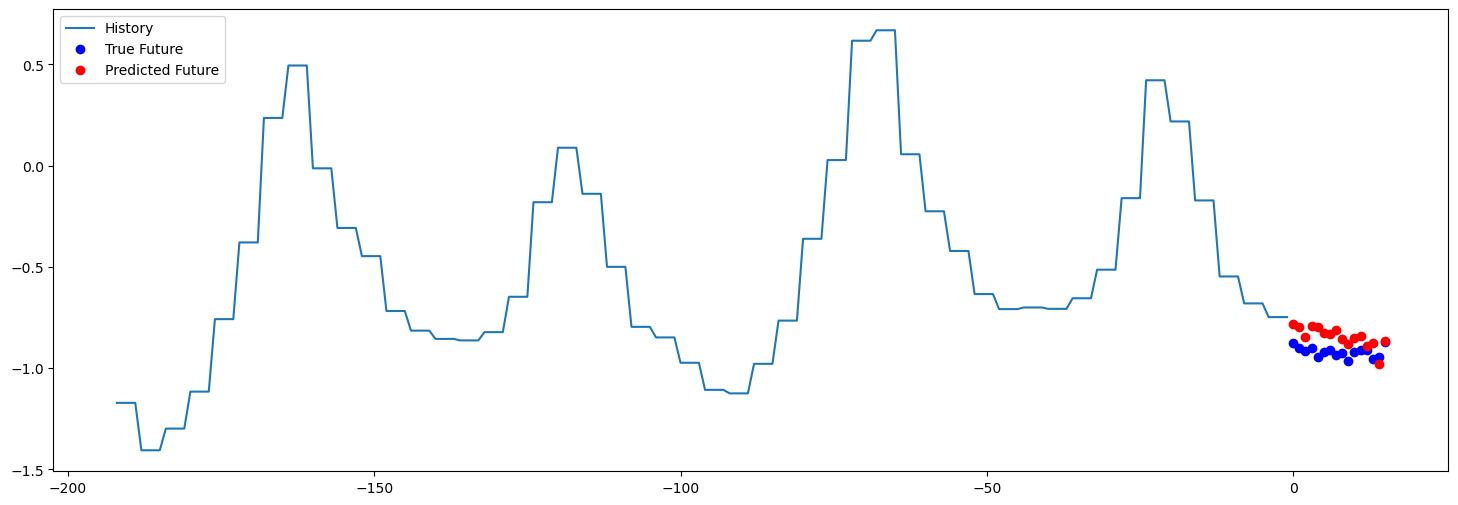

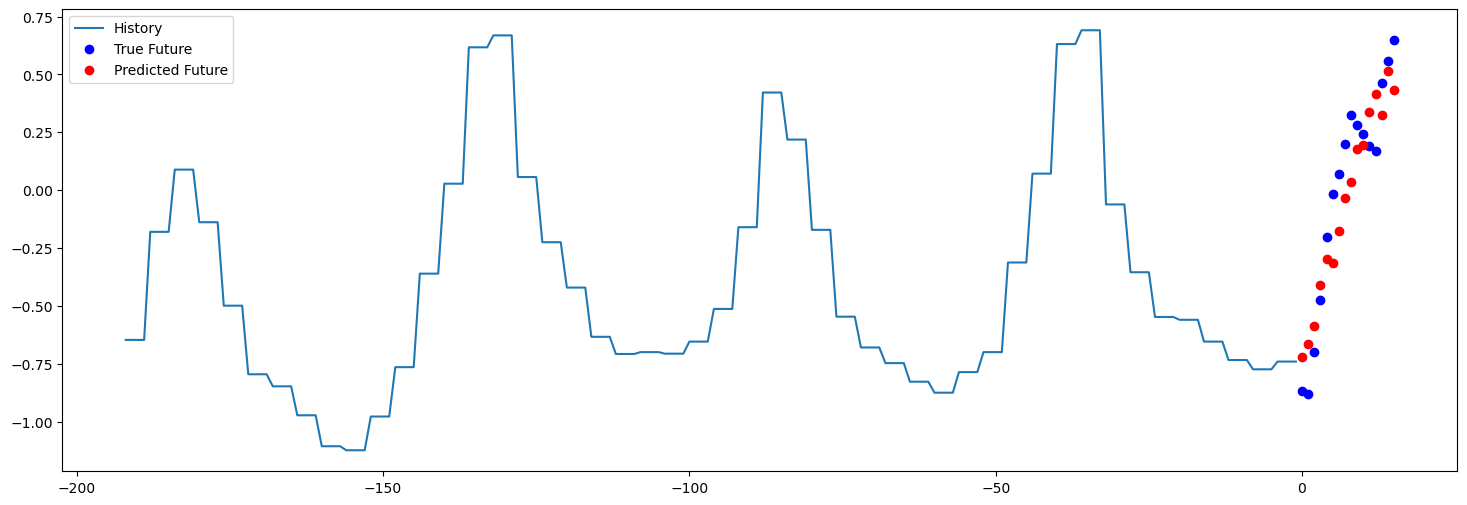

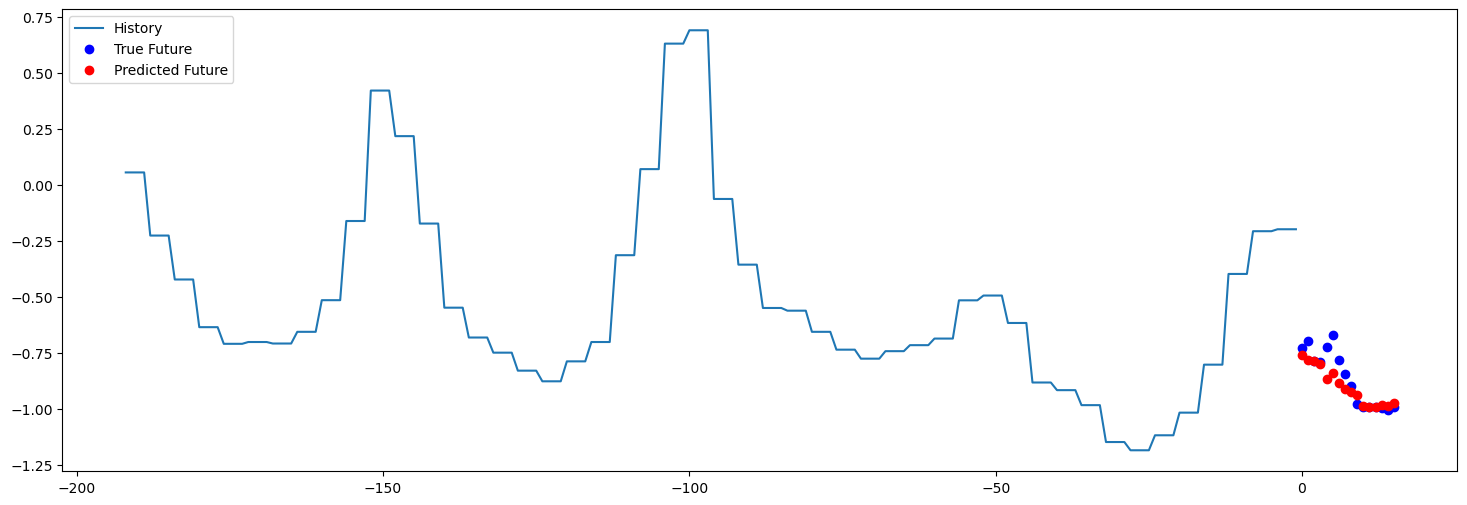

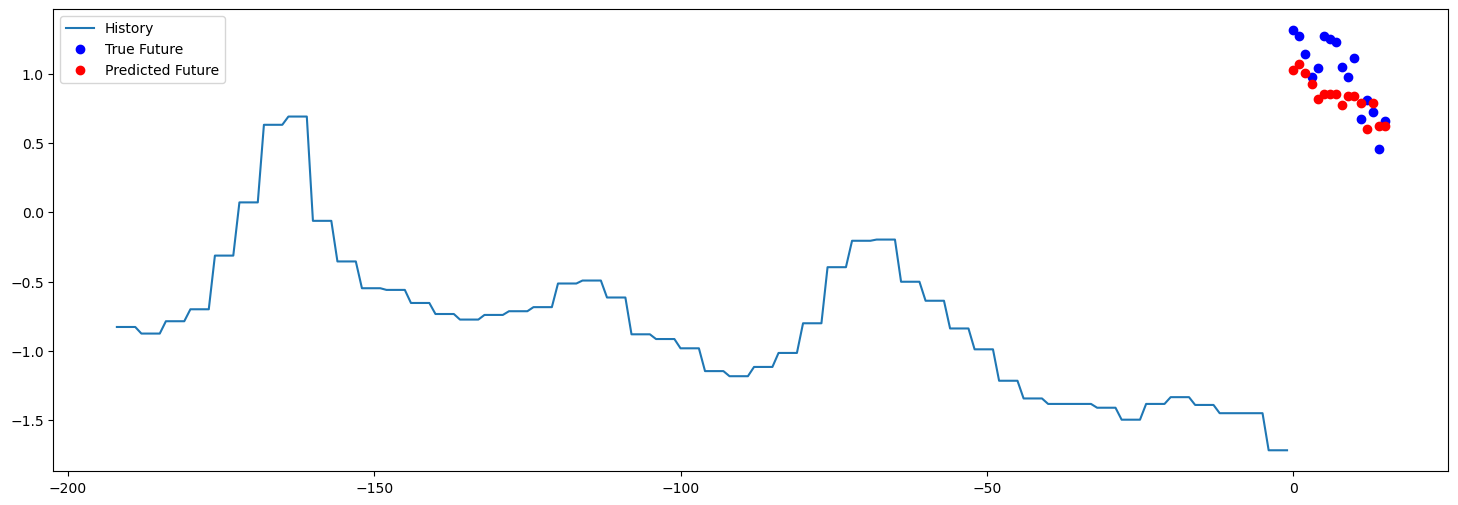

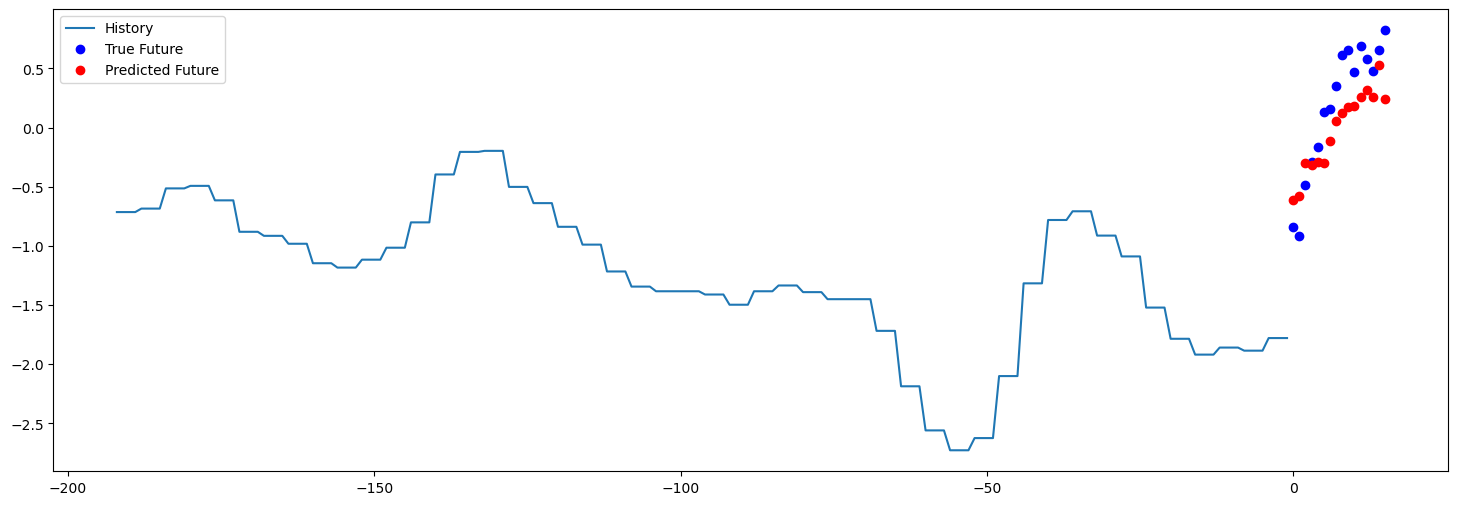

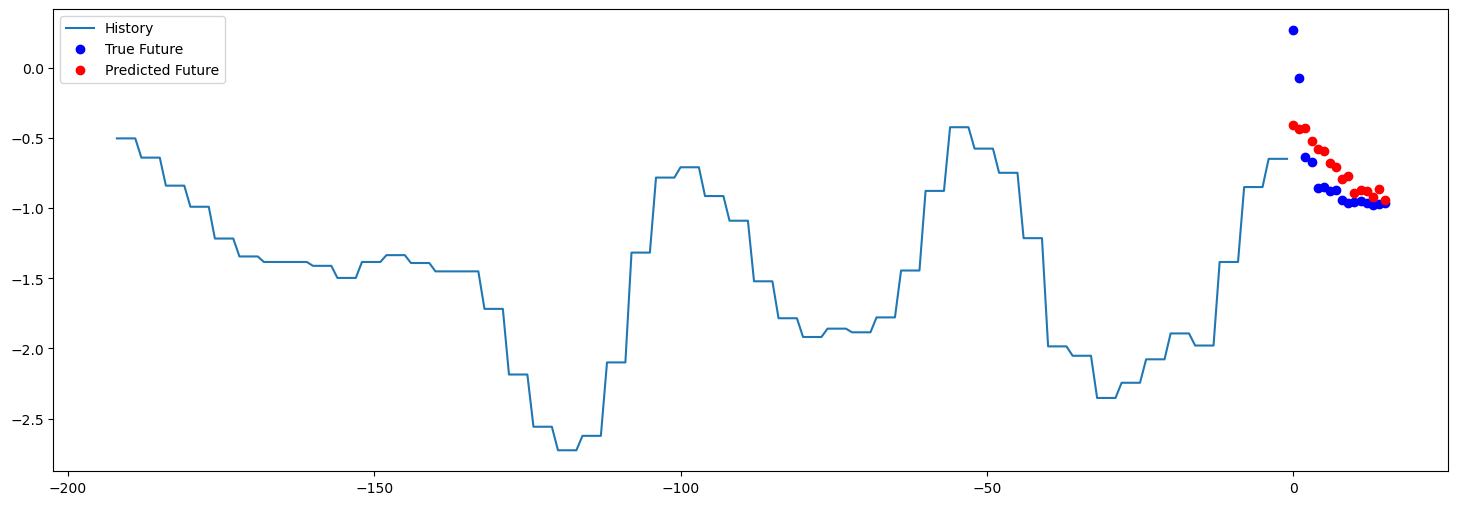

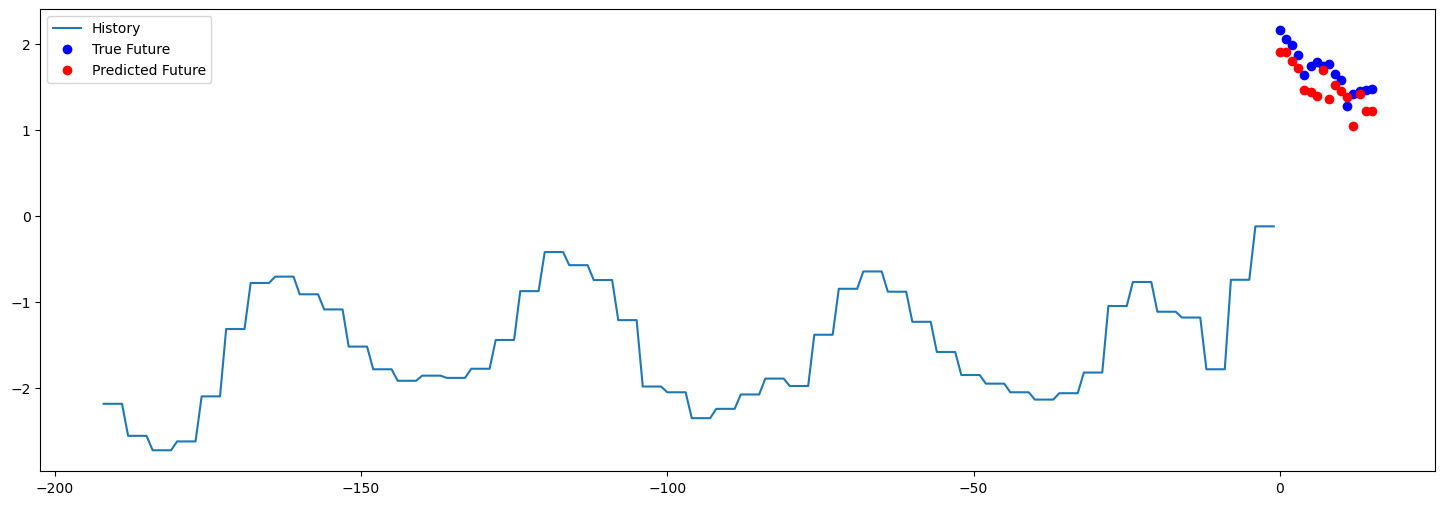

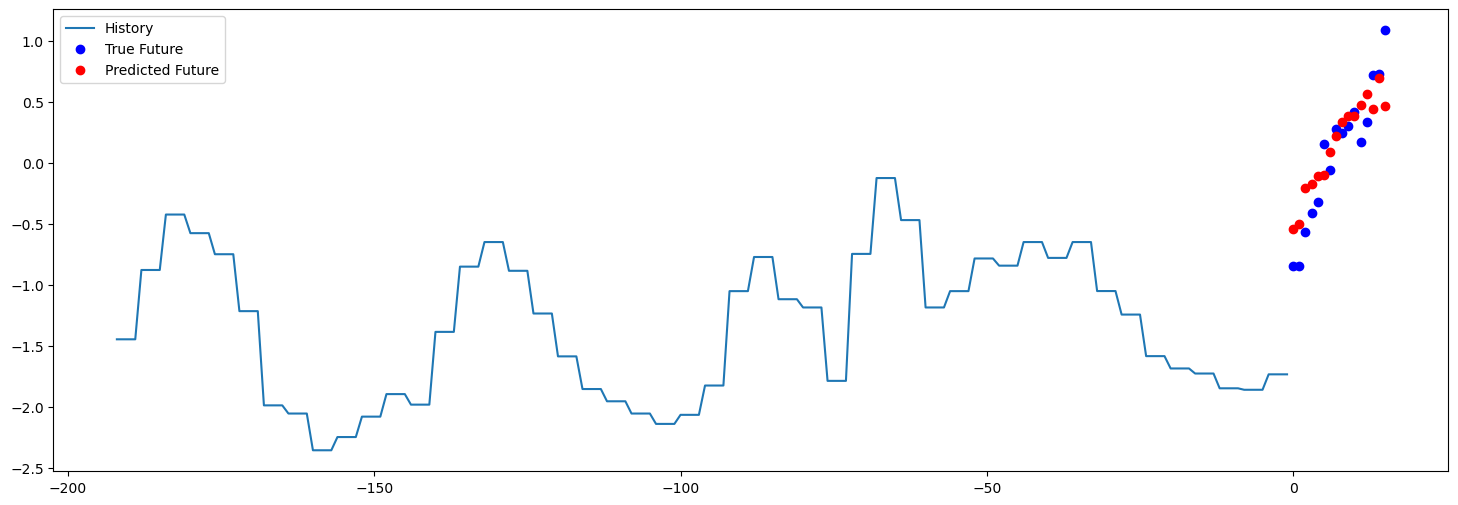

In [90]:
for x, y in val_data_multi.take(10):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])